# [실습] LangGraph 기초

랭그래프는 어플리케이션의 작동 과정을 Graph로 정의하고, 이를 통해 복잡한 Workflow를 실행합니다.   

기본 라이브러리를 설치합니다.

In [22]:
!pip install langgraph langchain langchain_google_genai langchain_community langchain_tavily bs4

  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached soupsieve-2.8-py3-none-any.whl.metadata (4.6 kB)
Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)
Using cached soupsieve-2.8-py3-none-any.whl (36 kB)

   ------------- -------------------------- 1/3 [beautifulsoup4]
   ---------------------------------------- 3/3 [bs4]



# Graph의 구성 요소: State, Node, Edge, Graph


시작 지점과 끝 지점을 표시한 그래프를 구성하고, 전체 그래프를 `invoke()`를 통해 실행합니다.

그래프는 점과 선으로 구성되는데요.  



이를 노드(Node, 정점), 엣지(Edge, 간선)라고 부릅니다.    

각각의 노드는 LLM 호출을 비롯한 하나의 기능을 수행하게 되며, 기능과 기능 사이의 연결을 엣지로 구성합니다.

### State

LangGraph의 Workflow는 State Diagram으로 볼 수 있습니다.   

전체 Workflow에서, State는 초기 State에서 시작해    
Node와 Edge를 통과하며 그 값이 수정되거나 추가되는 과정을 거치게 됩니다.   
  



State의 구조는 보통 가시성을 위해 타입 표시를 병행합니다.   
`TypedDict`나 `Pydantic`중 편한 것을 사용하면 되는데요.   
이번 교재에서는 공식 문서와 동일한 `TypedDict`를 사용하겠습니다.

In [2]:
# TypedDict: 타입 표시가 가능한 구조

from typing_extensions import TypedDict

class State(TypedDict):
    result: str
    secret: str

### Node

노드는 함수로 정의되는데, 주로 하나의 모듈을 하나의 노드로 구성합니다.   
State는 노드를 지나며 새로운 정보를 추가하거나, 값을 수정할 수 있습니다.

In [3]:
# state에 문자열을 추가하는 노드
def first(state):
    print("---Node 1---")
    return {"result": state['result'] +"랭그래프 1번 노드 통과\n"}

def second(state):
    print("---Node 2---")
    return {"result": state['result'] +"랭그래프 2번 노드 통과\n"}

### Edge와 Graph   

위에서 설정한 State를 이용하여 Graph를 정의합니다.

그래프에 노드와 엣지를 추가합니다.    
START와 END를 import하고, 시작점과 끝점을 정의합니다.

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 그래프 정의하기
builder = StateGraph(State)

# 노드 이름과 함수 이름은 같지 않아도 됨
builder.add_node("first", first)
builder.add_node("second", second)

builder.add_edge(START, "first")
builder.add_edge("first", "second")
builder.add_edge("second", END)

만든 그래프는 `compile()`을 통해 실행 가능한 Runnable 구조로 만들어집니다.

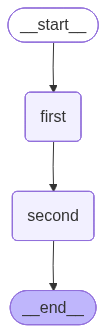

In [5]:
graph = builder.compile()

graph
# 간단한 Mermaid 기반의 시각화 지원

구성된 graph를 실행해 보겠습니다!   
state의 초기 상태를 Dictionary 형태로 전달합니다.

In [6]:
response = graph.invoke({'result':'시작!\n', 'secret':'비밀'})
response

---Node 1---
---Node 2---


{'result': '시작!\n랭그래프 1번 노드 통과\n랭그래프 2번 노드 통과\n', 'secret': '비밀'}

## 그래프에 LLM 포함시키기
이번에는 값이 여러 개인 State를 구성하고, 그래프로 만들어 보겠습니다.   
llm도 활용해 보겠습니다.

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

3개의 요소가 포함된 State를 구성합니다.

In [9]:
class State(TypedDict):
    integer: int
    root: int
    joke: str


2개의 노드를 구성합니다.

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def get_root(state):
    return {"root": int(state["integer"] ** 0.5)}

def get_joke(state):
    prompt = ChatPromptTemplate([
        ('system', '당신은 언어 유희의 달인입니다.'),
         ('user','{length} 문장 길이의 짧은 영어 유머를 만들어주세요. 각 문장마다 숫자를 붙이세요.')
    ])
    chain = prompt | llm | StrOutputParser()
    return {"joke": chain.invoke({'length':state['root']})}

그래프를 구성합니다.

In [12]:
# 그래프 구성
# 이미 존재하는 노드를 또 만들면 에러가 발생할 수 있으므로
# 그래프를 수정할 때에는 builder 초기화부터 꼭 하기

builder = StateGraph(State)

builder.add_node("get_root", get_root)
builder.add_node("get_joke", get_joke)

builder.add_edge(START, "get_root")
builder.add_edge("get_root", "get_joke")
builder.add_edge("get_joke", END)

그래프를 컴파일하고 실행합니다.

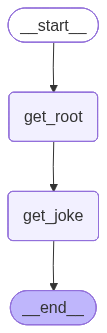

In [13]:
graph = builder.compile()
graph

In [14]:
initial_state = {'integer': 16}
response = graph.invoke(initial_state)

response

{'integer': 16,
 'root': 4,
 'joke': '알겠습니다! 언어 유희의 달인으로서, 짧고 유머러스한 영어 농담을 만들어 드리겠습니다.\n\n1.  Why did the tomato turn red?\n2.  Because it saw the salad dressing!\n3.  It was feeling a little saucy.\n4.  Lettuce all laugh together!'}

### 웹 검색 노드 만들기   


이번 실습에서는 웹 검색 툴 결과를 바탕으로, 실제 URL을 크롤링하여 문서의 내용을 가져오겠습니다.   

랭체인에서 웹 페이지를 크롤링하기 위해서는 대표적으로 아래 3개의 방법을 사용할 수 있습니다.

1. `WebBaseLoader` : BeautifulSoup4 기반의 기본 크롤러로, HTML 코드를 그대로 가져옵니다.
2. `Docling` : 다양한 포맷의 문서를 텍스트 포맷으로 변환하는 오픈 소스 프로젝트로, 유용하나 빠른 실행을 위해 GPU 성능이 다소 요구됩니다.
3. `FireCrawl`: API 기반의 유료 서비스로, 무료 라이센스는 총 500회 무료 사용이 가능합니다.   
WebBaseLoader를 사용하겠습니다 :)

In [23]:
os.environ['TAVILY_API_KEY'] = 'tvly-xxxx'
os.environ['USER_AGENT'] = 'MyAgent'

from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WebBaseLoader

def tavily_search(State):
    tavily_search = TavilySearch(max_results=5)

    # 검색 결과 수집
    search_results = tavily_search.invoke({'query': State['query']})['results']
    # search_results : url, Content 형식의 Dict List Return

    # URL 리스트 추출 (PDF 주소는 제외)
    urls = [result['url'] for result in search_results if 'pdf' not in result['url']]


    try:
        loader = WebBaseLoader(urls)
    except:
        loader = WebBaseLoader(urls, requests_kwargs={'verify':False})

    documents = loader.load()
    return {'context': documents}

result = tavily_search({'query': '멀티 에이전트 구조'})
result


{'context': [Document(metadata={'source': 'https://brunch.co.kr/@ukai/2', 'title': 'Multi Agent와 Agentic Workflow?', 'description': "이 두 가지가 다른거야...? | Prologue: 왜 지금 'AI 에이전트'에 다시 주목하는가? 대규모 언어 모델(LLM)의 등장은 단순한 '챗봇'의 시대를 넘어, 스스로 생각하고, 계획하며, 도구를 사용해 '실제로 일하는 AI', 즉 AI 에이전트의 시대를 열었습니다. 이제 AI는 단순히 질문에 답하는 것을 넘어, 복잡한 리서치를 수행하고, 코드를 디버깅하며, 마케팅 캠페인까지 자동화하", 'language': 'ko'}, page_content="  \n\n\nMulti Agent와 Agentic Workflow?       \n\n\n\n\n\n\n\n\n\n\n\n\n          메뉴 brunch          Multi Agent와 Agentic Workflow? 이 두 가지가 다른거야...? by Ukai  Jun 25. 2025    Prologue: 왜 지금 'AI 에이전트'에 다시 주목하는가?대규모 언어 모델(LLM)의 등장은 단순한 '챗봇'의 시대를 넘어, 스스로 생각하고, 계획하며, 도구를 사용해 '실제로 일하는 AI', 즉 AI 에이전트의 시대를 열었습니다. 이제 AI는 단순히 질문에 답하는 것을 넘어, 복잡한 리서치를 수행하고, 코드를 디버깅하며, 마케팅 캠페인까지 자동화하는 주체적인 행위자로 진화하고 있습니다.이러한 '일하는 AI'를 구현하는 방식에는 크게 두 가지 핵심 패러다임이 존재합니다: 바로 멀티 에이전트 시스템(Multi-Agent System, MAS)과 에이전틱 워크플로우(Agentic Workflow)입니다. 둘 다 여러 에이전트를 활용할 수 있지만, 그 철학과 구조, 작동 방식에는 근본적인 차이가 있습니다. 당신의 AI 프로젝트가 자율적인 전문가들의 '팀'을 필요로 하는지, 아

In [24]:
def get_query(State):
    prompt = ChatPromptTemplate([
         ('user','''{question}에 답변하기 위해
인터넷 검색을 사용하려고 합니다.
적절한 검색어 쿼리를 하나만 출력하세요.
쿼리만 출력하세요.''')
    ])
    chain = prompt | llm | StrOutputParser()
    return {"query": chain.invoke(State)}
    # State를 모두 입력해도, Prompt Template에 포함된 입력변수만 전달


def answer_question(State):
    prompt = ChatPromptTemplate([
        ('system', '''당신은 QA(Question-Answering)을 수행하는 Assistant입니다.
다음의 Context를 이용하여 Question에 답변하세요.
정확한 답변을 제공하세요.
만약 모든 Context를 다 확인해도 정보가 없다면,
"정보가 부족하여 답변할 수 없습니다."를 출력하세요.'''),

        ('user', '''Context: {context}
---
Question: {question}''')])
    chain = prompt | llm | StrOutputParser()
    return {"answer": chain.invoke(State)}

State를 만들고, 그래프를 구성합니다.

In [25]:
class State(TypedDict):
    question : str # 유저의 질문
    query: str # 질문에서 파생된 검색어
    answer: str # 답변
    context: str # 검색 결과


In [26]:
# 그래프 구성
builder = StateGraph(State)

builder.add_node("get_query", get_query)
builder.add_node("tavily_search", tavily_search)
builder.add_node("answer_question", answer_question)

builder.add_edge(START, "get_query")
builder.add_edge("get_query", "tavily_search")
builder.add_edge("tavily_search", "answer_question")
builder.add_edge("answer_question", END)


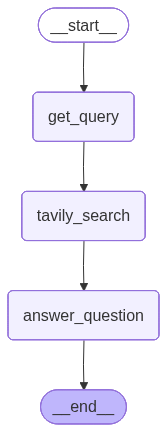

In [27]:
graph = builder.compile()
graph

In [28]:
result = graph.invoke({'question': 'Qwen 3 Omni 는 어떤 모델이야?'})
result

{'question': 'Qwen 3 Omni 는 어떤 모델이야?',
 'query': 'Qwen 3 Omni',
 'answer': 'Qwen3-Omni는 텍스트, 이미지, 오디오, 비디오를 처리할 수 있는 다중 모달(multimodal) 모델입니다. 이 모델은 엔드투엔드(end-to-end) 다국어 옴니 모델로, 텍스트와 자연스러운 음성으로 실시간 스트리밍 응답을 제공합니다.\n\n주요 특징은 다음과 같습니다:\n*   **다중 모달 처리**: 텍스트, 이미지, 오디오, 비디오 등 다양한 형태의 데이터를 처리합니다.\n*   **실시간 응답**: 텍스트 및 자연스러운 음성으로 실시간 스트리밍 응답을 제공합니다.\n*   **다국어 지원**: 119개 언어로 텍스트 상호작용을 지원하며, 19개 언어로 음성 이해, 10개 언어로 음성 생성을 지원합니다.\n*   **아키텍처**: Thinker-Talker MoE 아키텍처를 채택하여 텍스트, 이미지, 오디오, 비디오 전반에 걸쳐 인식과 생성을 통합합니다.\n*   **성능**: 단일 모달 모델과 비교하여 성능 저하 없이 텍스트, 이미지, 오디오, 비디오에서 최첨단 성능을 유지하며, 특히 오디오 작업에서 뛰어난 성능을 보입니다. (36개 오디오 및 오디오-시각 벤치마크 중 32개에서 오픈소스 SOTA, 22개에서 전체 SOTA 달성)',
 'context': [Document(metadata={'source': 'https://qwen.ai/blog?id=65f766fc2dcba7905c1cb69cc4cab90e94126bf4&from=research.latest-advancements-list', 'title': 'Qwen', 'description': 'Qwen Chat offers comprehensive functionality spanning chatbot, image and video understanding, image generation, document processing, web search i

전체 결과가 잘 실행되었지만, 중간 결과가 보고 싶다면 어떻게 해야 할까요?   
이후에 배울 `LangSmith`를 통해 트래킹할 수도 있고, 아래의 코드로 각 단계를 스트리밍할 수도 있습니다.

In [29]:
import pprint

# Streaming 참고
# https://langchain-ai.github.io/langgraph/concepts/streaming/#streaming-graph-outputs-stream-and-astream

for data in graph.stream({'question': '스탠포드의 멀티 에이전트 STORM 구조가 뭐야?'},
                         stream_mode='updates'):
    pprint.pprint(data)

{'get_query': {'query': 'Stanford STORM multi-agent architecture'}}
{'tavily_search': {'context': [Document(metadata={'source': 'https://medium.com/@cognidownunder/stanford-storm-revolutionizing-ai-powered-knowledge-curation-35ce51996c19', 'title': 'Stanford STORM: Revolutionizing AI-Powered Knowledge Curation | by Cogni Down Under | Medium', 'description': 'Stanford STORM: Revolutionizing AI-Powered Knowledge Curation nowledge Curation Stanford STORM: Revolutionizing AI-Powered Knowledge Curation In the ever-evolving landscape of artificial …', 'language': 'en'}, page_content='Stanford STORM: Revolutionizing AI-Powered Knowledge Curation | by Cogni Down Under | MediumSitemapOpen in appSign upSign inMedium LogoWriteSearchSign upSign inStanford STORM: Revolutionizing AI-Powered Knowledge CurationCogni Down Under5 min read·Jul 23, 2024--3ListenSharenowledge CurationStanford STORM: Revolutionizing AI-Powered Knowledge CurationIn the ever-evolving landscape of artificial intelligence, a ne

결과는 잘 나왔지만, 위 검색 결과를 보면 전처리가 많이 필요하거나, 프롬프트에 포함하지 않아도 되는 검색 결과들이 다소 존재할 수 있습니다.  



더 효과적인 어플리케이션을 구성한다면, 검색 결과를 검증하여 불필요한 토큰을 줄일 수 있겠습니다.   

<br><br>
이번 실습에서는 단순한 일직선 형태의 Flow를 그래프로 만들었기 때문에 위 작업들을 수행하지 않았지만,    
LangGraph의 기능을 활용하면 반복, 분기점, 중단 및 사용자의 중간 개입과 같은 요소들을 효율적으로 포함할 수 있습니다.    

